# Creating Federated Dataset for PFL Experiment

Federated dataset has more non-IID characteristics than traditional ML dataset, as users with different contexts independently generate their own data. In realistic scenarios, datasets for different users often come from different distributions and may possibly have conflicting labels. Because of this and the distributed nature of federated learning, the non-IID property of the federated datasets may sometimes make federated learning more challenging.

This tutorial covers how to create federated dataset in different ways for running PFL experiment:

1. creating `pfl` `Dataset` object
2. creating `FederatedDataset` with user IDs
3. creating IID `ArtificialFederatedDataset`
4. creating non-IID `ArtificialFederatedDataset`
5. customizing federated dataset

### 0. Setup environment
To use this notebook, follow these prerequisite steps:
1. Install `pfl` with `pip install 'pfl[pytorch]'`.
2. Install jupyter notebook with `pip install jupyter notebook`.
3. Start the notebook with `jupyter notebook`.

### 1. Creating a `pfl` Dataset Object
A `pfl.data.Dataset` object is the basic representation for a single user's dataset. Alternatively, this can also be used for building a central dataset for evaluation purpose (to be used with `pfl.callback.CentralEvaluationCallback`).   

In [1]:
import sklearn.datasets
from pfl.data.dataset import Dataset

# Create synthetic user data
user_id = 'pfl-user-0'
user_features, user_labels = sklearn.datasets.make_classification(n_samples=10, n_features=4)

# Create a pfl Dataset object
user_dataset = Dataset(raw_data=[user_features, user_labels], user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"Batch from `Dataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")

Batch from `Dataset`: 
x shape=(5, 4), x=[[-0.93396889  1.38144275 -0.25651903 -0.07058005]
 [ 1.47505537  1.60093462  2.18438982  0.21201945]
 [-1.25481843 -0.74810518 -1.5695337  -0.16404775]
 [ 2.02581709  0.76572641  2.32598324  0.25309372]
 [-0.61718078 -1.44501622 -1.27858726 -0.10931645]]
y shape=(5,), y=[1 1 0 0 0]


#### 1.1 Creating a PyTorch `pfl` Dataset Object
The above example showed how to create the `pfl` dataset in numpy format. `pfl`  supports data that are processed in PyTorch or TensorFlow tensors. We will focus on PyTorch for the purpose of this tutorial. The TensorFlow dataset implementation can be found at [tensorflow.py](https://github.com/apple/pfl-research/blob/main/pfl/data/tensorflow.py).

In [2]:
import os
os.environ['PFL_PYTORCH_DEVICE'] = 'cpu'

import torch

from pfl.internal.ops.selector import set_framework_module
from pfl.internal.ops import pytorch_ops, numpy_ops
from pfl.data.pytorch import PyTorchTensorDataset, PyTorchDataDataset

# Tell pfl to use pytorch as the backend ML framework
set_framework_module(pytorch_ops, old_module=numpy_ops)

In [3]:
# Option 1: Create a PyTorch pfl Dataset object based on PyTorch tensors
user_features, user_labels = torch.as_tensor(user_features), torch.as_tensor(user_labels)
user_dataset = PyTorchTensorDataset(tensors=[user_features, user_labels], user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"Batch from `PyTorchTensorDataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")

Batch from `PyTorchTensorDataset`: 
x shape=torch.Size([5, 4]), x=tensor([[-0.9340,  1.3814, -0.2565, -0.0706],
        [ 1.4751,  1.6009,  2.1844,  0.2120],
        [-1.2548, -0.7481, -1.5695, -0.1640],
        [ 2.0258,  0.7657,  2.3260,  0.2531],
        [-0.6172, -1.4450, -1.2786, -0.1093]], dtype=torch.float64)
y shape=torch.Size([5]), y=tensor([1, 1, 0, 0, 0])


In [4]:
# Option 2: Create a PyTorch pfl Dataset object based on torch.utils.data.Dataset
pytorch_data = torch.utils.data.TensorDataset(user_features, user_labels)
user_dataset = PyTorchDataDataset(raw_data=pytorch_data, user_id=user_id)

# Get a batch of the user dataset using Dataset.iter
batch_x, batch_y = next(user_dataset.iter(batch_size=5))
print(f"\nBatch from `PyTorchDataDataset`: \n"
      f"x shape={batch_x.shape}, x={batch_x}\n"
      f"y shape={batch_y.shape}, y={batch_y}")


Batch from `PyTorchDataDataset`: 
x shape=torch.Size([5, 4]), x=tensor([[-0.9340,  1.3814, -0.2565, -0.0706],
        [ 1.4751,  1.6009,  2.1844,  0.2120],
        [-1.2548, -0.7481, -1.5695, -0.1640],
        [ 2.0258,  0.7657,  2.3260,  0.2531],
        [-0.6172, -1.4450, -1.2786, -0.1093]], dtype=torch.float64)
y shape=torch.Size([5]), y=tensor([1, 1, 0, 0, 0])


### 2. Creating Federated Dataset with Real User Partition
Previous section showed how to create a single user dataset.  This section covers how to create a federated dataset which is a joint of multiple users' dataset. If the original dataset already have an attribute for user identifier, such as [StackOverflow](https://www.kaggle.com/datasets/stackoverflow/stackoverflow), [LEAF](https://leaf.cmu.edu) ans [FLAIR](https://github.com/apple/ml-flair), we can use the existing user parition in the dataset for more accurate simulation of non-IID characteristics in the real federated learning setting. 

In [5]:
from pfl.data import get_user_sampler, FederatedDataset

# Create a dataset partitioned by user
user_id_to_data = {}
n_users = 20
for i in range(n_users):
    user_id_to_data[i] = sklearn.datasets.make_classification(n_samples=i+1, n_features=4)
user_ids = list(user_id_to_data.keys())

# Create user sampler to sample user uniformly at random
user_sampler = get_user_sampler(sample_type="random", user_ids=user_ids)
federated_dataset = FederatedDataset.from_slices(data=user_id_to_data, user_sampler=user_sampler)

# Iterate federated dataset to get artificial user dataset
print("FederatedDataset with real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user with user_id={user_dataset.user_id} has size of {len(user_dataset)}.")

FederatedDataset with real user partition: 
	Real user with user_id=13 has size of 14.
	Real user with user_id=11 has size of 12.
	Real user with user_id=4 has size of 5.
	Real user with user_id=8 has size of 9.
	Real user with user_id=10 has size of 11.


#### 2.1 Creating a `PyTorchFederatedDataset` Object
In certain scenario, it might be beneficial to use `PyTorchFederatedDataset` for speeding up data loading. 

In [6]:
from pfl.data.pytorch import PyTorchFederatedDataset

class PyTorchDataset(torch.utils.data.Dataset):
    def __init__(self, user_id_to_data):
        self._user_id_to_data = user_id_to_data

    def __getitem__(self, i):
        return [torch.as_tensor(x) for x in self._user_id_to_data[i]]

    def __len__(self):
        return len(self._user_id_to_data)


pytorch_dataset = PyTorchDataset(user_id_to_data)
federated_dataset = PyTorchFederatedDataset(dataset=pytorch_dataset, user_sampler=user_sampler)
# Iterate federated dataset to get artificial user dataset
print("PyTorchFederatedDataset with real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user {i} has size of {len(user_dataset)}.")

PyTorchFederatedDataset with real user partition: 
	Real user 0 has size of 13.
	Real user 1 has size of 18.
	Real user 2 has size of 7.
	Real user 3 has size of 16.
	Real user 4 has size of 7.


#### 2.2 Creating a `FederatedDataset` with `torch.utils.data.Dataset`
If a user dataset is too large to fit into memory, `pfl` also supports `torch.utils.data.Dataset` for creating federated dataset.


In [7]:
def make_dataset_fn(user_id):
    # Create a `torch.utils.data.Dataset` for a single user
    user_data = [torch.as_tensor(data) for data in user_id_to_data[user_id]]
    pytorch_data = torch.utils.data.TensorDataset(*user_data)
    return PyTorchDataDataset(raw_data=pytorch_data, user_id=user_id)

federated_dataset = FederatedDataset(make_dataset_fn=make_dataset_fn, user_sampler=user_sampler)
print("FederatedDataset with torch.utils.data.Dataset and real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user {i} has size of {len(user_dataset)}.")

FederatedDataset with torch.utils.data.Dataset and real user partition: 
	Real user 0 has size of 5.
	Real user 1 has size of 7.
	Real user 2 has size of 5.
	Real user 3 has size of 11.
	Real user 4 has size of 12.


### 3. Creating IID Artificial Federated Dataset
The previous section assumes that a dataset has user IDs, which is often not the case for many existing ML datasets (e.g. CIFAR10). For those datasets, `pfl` supports converting them to Artificial Federated Dataset, meaning that there is no user ID associated with the dataset and the user partition will be artificial, which is useful for experimenting existing ML datasets. This section covers how to create an Artificial Federated Dataset assuming the data distribution between users is IID. 

In [8]:
import numpy as np
from pfl.data import ArtificialFederatedDataset, get_data_sampler


n_samples = 1000
features, labels = sklearn.datasets.make_classification(n_samples=n_samples, n_features=8, n_informative=4, n_classes=5)
# Create data sampler to sample each artificial user dataset as a random subset of the original dataset
data_sampler = get_data_sampler(sample_type="random", max_bound=n_samples)

# Option 1: Create an artificial federated dataset where each user dataset has constant size of 10
sample_dataset_len = lambda: 10
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("User dataset size is a constant: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")

User dataset size is a constant: 
	Artificial user 0 has size of 10
	Artificial user 1 has size of 10
	Artificial user 2 has size of 10
	Artificial user 3 has size of 10
	Artificial user 4 has size of 10


In [9]:
# Option 2: Create an artificial federated dataset where each user dataset size follows Poisson distribution
sample_dataset_len = lambda: max(1, np.random.poisson(10))
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("\nUser dataset size follows a Poisson distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")


User dataset size follows a Poisson distribution: 
	Artificial user 0 has size of 12
	Artificial user 1 has size of 7
	Artificial user 2 has size of 7
	Artificial user 3 has size of 13
	Artificial user 4 has size of 12


In [10]:
# For visualization in the notebook
!pip -q install matplotlib PyQt5

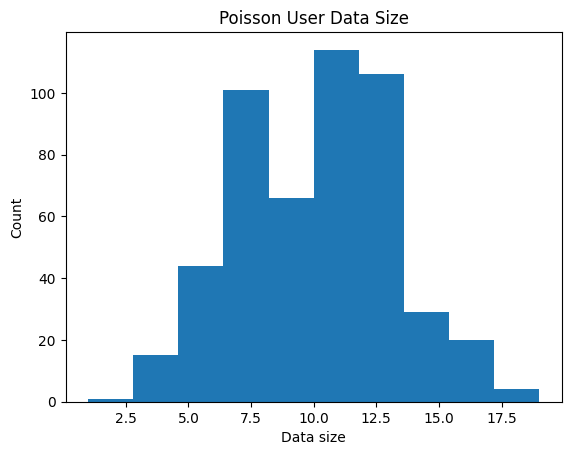

In [11]:
import matplotlib.pyplot as plt

# Visualize the size of user dataset with Poisson distribution
n = 500
plt.hist([len(next(federated_dataset)[0]) for _ in range(n)])
plt.title('Poisson User Data Size')
plt.xlabel('Data size')
plt.ylabel('Count')
plt.show()

### 4. Creating non-IID Artificial Federated Dataset
As mentioned before, in the real federated setting, the federated data has many non-IID characteristics in its distribution. This section shows how to artificially simulate the case for a classification dataset where the user label distribution is non-IID and follows a Dirichlet distribution (a common assumption in federated learning research). 

#### 4.1 Sampling non-IID user dataset dynamically with `ArtificialFederatedDataset`
The first option is to change the `data_sampler` in a way so that the user label distribution follows a Dirichlet distribution. The user dataset is sampled on the fly and there is no fixed user partition like as in [Section 3.2](#3.2-Partitioning-the-dataset-into-fixed-artificial-users-with-FederatedDataset) below.

In [12]:
# Create data sampler to sample each artificial user has label distribution follows a Dirichlet distribution.
dirichlet_alpha = [0.1] * 5
data_sampler = get_data_sampler(sample_type="dirichlet", labels=labels, alpha=dirichlet_alpha)

# Create an artificial federated dataset with a Dirichlet data sampler
sample_dataset_len = lambda: 20
federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[features, labels], 
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len,
)
# Iterate federated dataset to get artificial user dataset
print("ArtificialFederatedDataset with Dirichlet label distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)} with unique labels={np.unique(user_dataset.raw_data[1])}")

ArtificialFederatedDataset with Dirichlet label distribution: 
	Artificial user 0 has size of 20 with unique labels=[0 1]
	Artificial user 1 has size of 20 with unique labels=[1 4]
	Artificial user 2 has size of 20 with unique labels=[0 1]
	Artificial user 3 has size of 20 with unique labels=[0]
	Artificial user 4 has size of 20 with unique labels=[1 4]


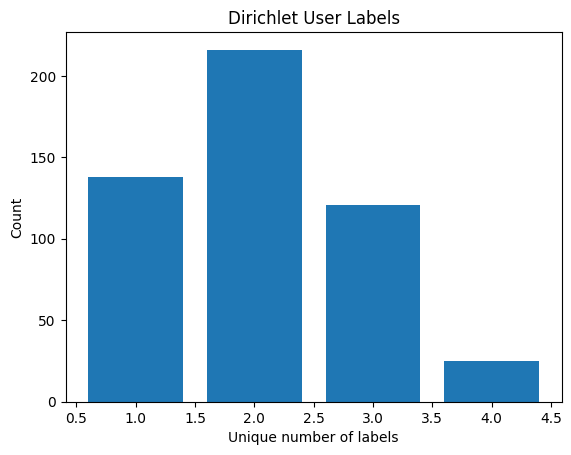

In [13]:
# Visualize the number of user unique labels with Dirichlet distribution
n = 500
unique_labels = [len(np.unique(next(federated_dataset)[0].raw_data[1])) for _ in range(n)]
values, counts = np.unique(unique_labels, return_counts=True)
plt.bar(values, counts)
plt.title('Dirichlet User Labels')
plt.xlabel('Unique number of labels')
plt.ylabel('Count')
plt.show()

#### 4.2 Partitioning the dataset into fixed artificial users with `FederatedDataset`
An alternative to the above is to partition the original dataset into a fixed set of artificial users where each user's label distribution follows a Dirichlet distribution. The difference of this option is that the user partitions are constructed once using all data and remains the same throughout the training. 

In [14]:
# Create a federated dataset with fixed user partition
# alpha=0.01 is a extreme case where each user likely has only data from 1 class
federated_dataset = FederatedDataset.from_slices_with_dirichlet_class_distribution(
    data=[features, labels],
    labels=labels,
    alpha=0.01,
    user_dataset_len_sampler=sample_dataset_len)

# Iterate federated dataset to get artificial user dataset
print("FederatedDataset with Dirichlet label distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)} with unique labels={np.unique(user_dataset.raw_data[1])}")

FederatedDataset with Dirichlet label distribution: 
	Artificial user 0 has size of 20 with unique labels=[0]
	Artificial user 1 has size of 20 with unique labels=[3 4]
	Artificial user 2 has size of 20 with unique labels=[0 4]
	Artificial user 3 has size of 20 with unique labels=[2]
	Artificial user 4 has size of 20 with unique labels=[0]


### 5. Customizing Federated Dataset
This section covers customizations to federated dataset for different needs, in case the above general usage does not satisify.

#### 5.1 Creating memory-efficient HDF5 Federated Dataset
Many ML datasets can get too large to fit into memory and HDF5 is a memory friendly format for processing Numpy arrays. HDF5 can be easily integrated with `FederatedDataset` for large scale PFL experiments.

In [15]:
import h5py
import tempfile

# Create a HDF5 file.
temp = tempfile.NamedTemporaryFile()
with h5py.File(temp.name, 'w') as h5:
    for user_id in user_id_to_data:
        features, labels = user_id_to_data[user_id]
        h5[f'/{user_id}/features'] = features
        h5[f'/{user_id}/labels'] = labels

# Customized function for creating a user dataset given the user ID
def make_dataset_fn(user_id):
    with h5py.File(temp.name, 'r') as h5:
        features = np.array(h5[f'/{user_id}/features'])
        labels = np.array(h5[f'/{user_id}/labels'])
        # Randomly shuffle the user dataset each time when loading
        data_order = np.random.permutation(len(features))
    return Dataset(raw_data=[features[data_order], labels[data_order]], user_id=user_id)

# Create FederatedDataset with the customized make_dataset_fn
federated_dataset = FederatedDataset(make_dataset_fn=make_dataset_fn, user_sampler=user_sampler)

# Iterate federated dataset to get artificial user dataset
print("Customized HDF5 FederatedDataset with real user partition: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tReal user with user_id={user_dataset.user_id} has size of {len(user_dataset)}.")

# Delete the temp HDF5 file
temp.close()

Customized HDF5 FederatedDataset with real user partition: 
	Real user with user_id=17 has size of 18.
	Real user with user_id=6 has size of 7.
	Real user with user_id=0 has size of 1.
	Real user with user_id=8 has size of 9.
	Real user with user_id=17 has size of 18.


#### 5.2 Creating `ArtificialFederatedDataset` from HuggingFace datasets 
HuggingFace [datasets](https://huggingface.co/datasets) provides a collection of ML datasets and it can be integrated with `pfl` easily to create `ArtificialFederatedDataset`.

In [16]:
# Install the HuggingFace modules first
!pip3 -q install datasets transformers

In [17]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding


# Follow the tutorial from https://huggingface.co/docs/datasets/use_dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
hf_dataset = load_dataset("rotten_tomatoes", split="train").map(lambda x: tokenizer(x['text']), batched=True)
hf_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer, max_length=64)

def make_dataset_fn(indices):
    data = data_collator([hf_dataset[int(i)] for i in indices])
    return PyTorchTensorDataset(tensors=tuple(data.values()))

data_sampler = get_data_sampler(sample_type="random", max_bound=len(hf_dataset))
sample_dataset_len = lambda: max(1, np.random.poisson(16))
federated_dataset = ArtificialFederatedDataset(
    make_dataset_fn=make_dataset_fn,
    data_sampler=data_sampler,
    sample_dataset_len=sample_dataset_len)

# Iterate federated dataset to get artificial user dataset
print("\nHuggingFace User dataset size follows a Poisson distribution: ")
for i in range(5):
    user_dataset, seed = next(federated_dataset)
    print(f"\tArtificial user {i} has size of {len(user_dataset)}")

/Users/congzhengsong/Repos/nnlm-pfl-deps/miniconda3/envs/pfl-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-19 14:51:06.724183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



HuggingFace User dataset size follows a Poisson distribution: 
	Artificial user 0 has size of 14
	Artificial user 1 has size of 16
	Artificial user 2 has size of 22
	Artificial user 3 has size of 14
	Artificial user 4 has size of 15


/Users/congzhengsong/Repos/nnlm-pfl-deps/miniconda3/envs/pfl-py310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2636: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
